In [1]:
import torch
from model_architecture import GPTModel, GPTModel_DyT

In [2]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256, # This is non-standard, using for training purposes (1024 is normal for GPT-2 models)
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate_emb': 0.1,
    'drop_rate_shortcut': 0.1,
    'drop_rate_attn': 0.1,
    'qkv_bias': False,
}

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

model_dyt = GPTModel_DyT(GPT_CONFIG_124M)
model_dyt.eval()

GPTModel_DyT(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_DyT(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dyt1): DyT()
      (dyt2): DyT()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock_DyT(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [4]:
import tiktoken
from model_architecture import generate_text_simple

In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [6]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)
print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [7]:
# Load the Verdict story for training and validation
# Later explore training on a larger dataset to test the capability of the M4 Pro chip

file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [8]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Characters: {total_characters}")
print(f"Tokens: {total_tokens}")

Characters: 20479
Tokens: 5145


In [9]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [10]:
from data_loaders import create_dataloader_v1
torch.manual_seed(123)

In [11]:
train_loader = create_dataloader_v1(
    train_data,
    batchsize=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batchsize=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [12]:
print("Train loader")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [14]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)
model_dyt.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    train_loss_dyt = calc_loss_loader(train_loader, model_dyt, device)
    val_loss_dyt = calc_loss_loader(val_loader, model_dyt, device)
    
print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")
print(f"Training loss DyT: {train_loss_dyt}")
print(f"Validation loss DytT: {val_loss_dyt}")

Training loss: 0.16638348168796963
Validation loss: 6.711029529571533
Training loss DyT: 10.865442276000977
Validation loss DytT: 10.871414184570312


In [16]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() #Turns off dropout layers in the model for evaluation
    with torch.no_grad(): #Turns off gradient tracking in torch to reduce computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss
    
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' '))
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader,
                                                      val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}), "
                      f"Val loss {val_loss:.3f})"
                )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen
        

In [24]:
# Train a simple model for 10 epochs
torch.manual_seed(123)
#Model defined above, uncomment if this isn't true
#model = GPTModel(GPT_CONFIG_124M)
#model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context='Every effort moves you', tokenizer=tokenizer
)

# train_losses_dyt, val_losses_dyt, tokens_seen_dyt = train_model_simple(
#     model_dyt, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context='Every effort moves you', tokenizer=tokenizer
# )

Ep 1 (Step 000000): Train loss 0.464), Val loss 7.254)
Ep 1 (Step 000005): Train loss 0.227), Val loss 6.892)
Every effort moves you?" "I and pushed one of the deep arm-chairs forward. "There: make yourself comfortable--and here are the cigars you like." He was _not_ interesting--if I saw that, my eye fell on a small picture
Ep 2 (Step 000010): Train loss 0.163), Val loss 7.026)
Ep 2 (Step 000015): Train loss 0.153), Val loss 6.885)
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, I remember getting off a prodigious phrase about the sketch of the donkey. "There were days when I
Ep 3 (Step 000020): Train loss 0.104), Val loss 7.100)
Ep 3 (Step 000025): Train loss 0.092), Val loss 7.031)
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, when I back his head to look up at the sketch of the donkey. "There were days when I
Ep 4 (Step 000030): Train l

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens seen')
    fig.tight_layout()
    plt.show()

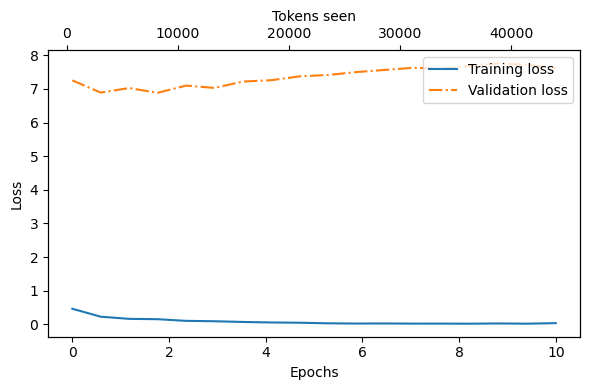

In [25]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#plot_losses(epochs_tensor, tokens_seen_dyt, train_losses_dyt, val_losses_dyt)

In [ ]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [22]:
# from model_architecture import generate

# torch.manual_seed(123)


In [23]:
# token_ids = generate(
#     model=model,
#     idx=text_to_token_ids("Every effort moves you", tokenizer),
#     max_new_tokens=5,
#     context_size=GPT_CONFIG_124M['context_length'],
#     top_k=25,
#     temperature=1.4
# )
# print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'eod_id' is not defined